<a href="https://colab.research.google.com/github/2pterons/multicampus/blob/main/2_20211005_KoGPT2_idiom_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **⦁ GPT** 구조

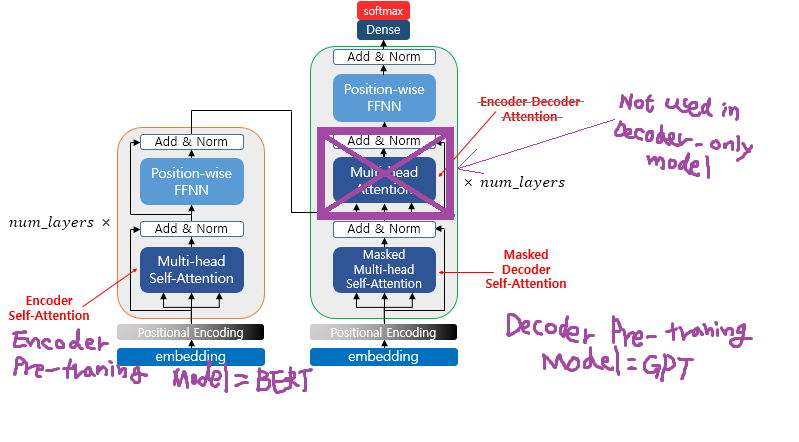

<br/><br/>

# **KoGPT2를 이용한 감성분석**
<br/>


### 1. 라이브러리 설치 및 임포트

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data


In [ ]:
!pip install --upgrade mxnet>=1.6.0
!pip install gluonnlp
!pip install transformers
!pip install sentencepiece

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer, SentencepieceDetokenizer
from transformers import TFGPT2LMHeadModel
import tensorflow as tf

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

     |████████████████████████████████| 344 kB 5.1 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595738 sha256=47c1bcb522600b270e8d476c6710b8b9757541f220cea33ee28272146dff7fdc
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 2.9 MB 5.0 MB/s 
     |████████████████████████████████| 895 kB 48.8 MB/s 
     |████████████████████████████████| 3.3 MB 31.6 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 636 kB 57.0 MB/s 
     |████████████████████████████████| 109 kB 55.3 MB/s 
     |████████████████████████████████| 546 kB 46.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.2 MB/s 


<br/><br/>
### 2. pickle을 이용해 final_idiom_dataset_for_ko.pkl 읽어오기 및 변수에 담기

In [ ]:
import pickle
#with open('./final_idiom_dataset_for_ko.pkl', 'rb') as f:
with open('./2/train_34614.pkl','rb') as f:
  text = pickle.load(f)

In [ ]:
text.head()

,ko,Label
0,그럼에도 불구하고 올림픽에서 가장 멋진 부분 중 하나는 바로 사진입니다.,1
1,"식당에 종사하는 사람은 위생복을 착용하여야 하며, 항상 청결을 유지하여야 한다.",0
2,대법원 1부(주심 권순일 대법관)는 28일 강아무개씨 등 정보유출 피해자 341명이...,0
3,경제전문가들은 후반기에 경기가 좀 좋아진다 하더라도 연말까지 400억 헤알에 달하는...,0
4,이 자리에서 이 대표는 “일자리 문제가 어려운데 당에서도 민생연석회의 출범을 조만간...,1


In [ ]:
data = text['ko']
data.head()

0             그럼에도 불구하고 올림픽에서 가장 멋진 부분 중 하나는 바로 사진입니다.
1         식당에 종사하는 사람은 위생복을 착용하여야 하며, 항상 청결을 유지하여야 한다.
2    대법원 1부(주심 권순일 대법관)는 28일 강아무개씨 등 정보유출 피해자 341명이...
3    경제전문가들은 후반기에 경기가 좀 좋아진다 하더라도 연말까지 400억 헤알에 달하는...
4    이 자리에서 이 대표는 “일자리 문제가 어려운데 당에서도 민생연석회의 출범을 조만간...
Name: ko, dtype: object

In [ ]:
target = text['Label']
target.head()

0    1
1    0
2    0
3    0
4    1
Name: Label, dtype: int64

<br/><br/>
### pre-training 데이터


In [ ]:
dx_train,dx_test, dy_train, dy_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

MY_PATH = '/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/'
MODEL_PATH = MY_PATH + 'gpt_ckpt'
TOKENIZER_PATH = MY_PATH + 'gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH, num_best=0, alpha=0)
detokenizer = SentencepieceDetokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token = None,
                                               sep_token = None,
                                               cls_token = None,
                                               unknown_token = '<unk>',
                                               padding_token = '<pad>',
                                               bos_token = '<s>',
                                               eos_token = '</s>')
# vocab --> Vocab(size=50000, unk="<unk>", reserved="['<pad>', '<s>', '</s>']")


In [ ]:
MAX_LEN = 60
def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)


In [ ]:
x_train, y_train = build_data(dx_train, dy_train)
x_test, y_test = build_data(dx_test, dy_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((27691, 62), (27691, 1), (6923, 62), (6923, 1))

In [ ]:
x_test[0]


array([    0, 12277,  6768,  7810,  1079, 19593,   394,  4268,   351,
        9784,   961, 47445,   126, 47535, 47616, 47454,  2863, 11630,
       28761,   244,   369, 47464,  7312,  3975, 47611,   330, 47440,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     1])

In [ ]:
len(x_test[0])

62

In [ ]:
print(len(vocab))
print(vocab.padding_token, ':', vocab[vocab.padding_token])
print(vocab.bos_token, ': ', vocab[vocab.bos_token])
print(vocab.eos_token, ': ', vocab[vocab.eos_token])
print(vocab.unknown_token, ': ', vocab[vocab.unknown_token])


50000
<pad> : 3
<s> :  0
</s> :  1
<unk> :  5


In [ ]:
word2idx = {k:v for k, v in vocab.token_to_idx.items()}
idx2word = {v:k for k, v in word2idx.items()}
idx2word[5000]


'▁전세'

In [ ]:
# 참고 : https://nlp.gluon.ai/api/modules/data.html
tokenizer('나는 자연어처리를 공부하고 있다')

print([idx2word[i] for i in x_test[0]])

['<s>', '▁사용자가', '▁별도의', '▁설비', '▁또는', '▁기기를', '▁사용', '하고자', '▁할', '▁때에는', '▁별', '지', '▁제', '6', '호', '서', '식에', '▁의하여', '▁구청장', '에게', '▁검', '인', '▁신청을', '▁하여', '야', '▁한다', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '</s>']


In [ ]:
gpt_model = TFGPT2LMHeadModel.from_pretrained(MODEL_PATH)
gpt_model.summary()


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#pre-trainmodel
# TFGPT2MainLayer는 fine-tuning을 하지 않는다.
gpt_model.trainable = True
gpt_model.summary() # gtp_model을 다시 확인한다. trainable params = 0


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# GPT2 입력
# ---------
x_input = Input(batch_shape = (None, MAX_LEN + 2), dtype = tf.int32)


In [ ]:
# GPT2 출력
# ---------
# output_gpt[0]        --> <KerasTensor: shape=(None, 60, 50000) dtype=float32
# output_gpt[0][:, -1] --> <KerasTensor: shape=(None, 50000) dtype=float32
output_gpt = gpt_model(x_input)[0][:, -1]


In [ ]:
# Downstream task : idiom classifier
# -------------------------------------
# 사전학습데이터 없이 Dense Layer만 붙여놓은것
y_output = Dense(1, activation = 'sigmoid')(output_gpt)
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 2e-5))
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model (TFGPT2 TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 124,292,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=32)

Epoch 1/3
866/866 [==============================] - 283s 307ms/step - loss: 0.4203 - val_loss: 0.1594
Epoch 2/3
866/866 [==============================] - 263s 304ms/step - loss: 0.1398 - val_loss: 0.1208
Epoch 3/3
866/866 [==============================] - 263s 303ms/step - loss: 0.0975 - val_loss: 0.0971


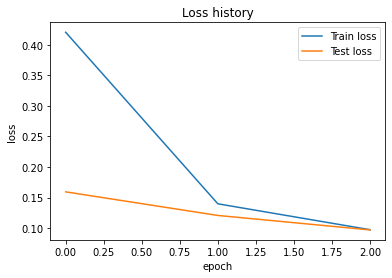

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
gpt_model.trainable = False
gpt_model.summary()

Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 0
Non-trainable params: 124,242,432
_________________________________________________________________


In [ ]:
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-6))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model (TFGPT2 TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 50,001
Non-trainable params: 124,242,432
_________________________________________________________________


In [ ]:
x_train

array([[    0,   167,  1286, ...,     3,     3,     1],
       [    0,   427, 10066, ...,     3,     3,     1],
       [    0,  2143, 47453, ...,     3,     3,     1],
       ...,
       [    0,   512,   232, ...,     3,     3,     1],
       [    0,   568, 36132, ...,     3,     3,     1],
       [    0, 14504, 10120, ...,     3,     3,     1]])

In [ ]:
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=32)

Epoch 1/3
866/866 [==============================] - 122s 126ms/step - loss: 0.0634 - val_loss: 0.0997
Epoch 2/3
866/866 [==============================] - 106s 123ms/step - loss: 0.0621 - val_loss: 0.1029
Epoch 3/3
866/866 [==============================] - 106s 123ms/step - loss: 0.0616 - val_loss: 0.1025


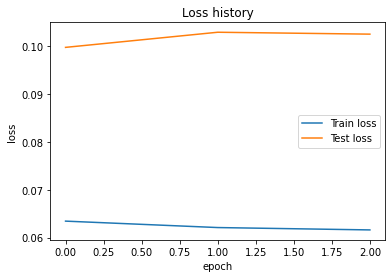

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


In [ ]:
"""from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
# 오차행렬
# 정확도
print("accuracy:", accuracy_score(y_test, y_pred))

# 정밀도
print("precision:", precision_score(y_test, y_pred))

# 재현율
print("recall:", recall_score(y_test, y_pred))

# f1-score
print("F1-Score:", f1_score(y_test, y_pred))"""

'from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix\n# 오차행렬\n# 정확도\nprint("accuracy:", accuracy_score(y_test, y_pred))\n\n# 정밀도\nprint("precision:", precision_score(y_test, y_pred))\n\n# 재현율\nprint("recall:", recall_score(y_test, y_pred))\n\n# f1-score\nprint("F1-Score:", f1_score(y_test, y_pred))'

In [ ]:
# 새로운 문장으로 테스트
#new_test = pd.read_csv('./idiom_dataset(18808).csv')
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data
import pickle
with open('./1/test_3000.pkl', 'rb') as f:
  new_test = pickle.load(f)
new_test

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data


,ko,Label
0,더 큰 문제는 자영업자들이 상황을 타개하기 위해 부채를 확대하고 있어 잠재부실에 대...,0
1,팝콘이랑 콜라 쓰레기는 버리고 오지 왜 들고 다니니?,0
2,"삼성전자의 가시적인 목표는 파운드리 분야에서 대만 TSMC를 따라잡고, AP와 모뎀...",1
3,그런 만큼 이 시점에 우리 정부가 적극 개입해 북-미 사이에 다리를 놓는 것도 필요...,1
4,김 후보자는 개성공단 재개에 대한 원유철 자유한국당 의원의 질의에는 “지금 상황에서...,1
...,...,...
2995,마이크론은 글로벌 D램 시장에서 삼성전자와 SK하이닉스에 이어 점유율 3위 업체로 ...,1
2996,데이식스는 위촉식에서 “KYWA가 추진하는 청소년 관련 행사 및 홍보 활동에 적극 ...,0
2997,머리끝에 상판을 제외하고 그곳에는 상부구조가 없었던 거처럼 보입니다.,0
2998,색다른 매력을 지닌 배우들과 개성 있는 이야기가 한 데 어우러져 안방극장을 뜨겁게 ...,0


In [ ]:
#new_test['Label'] = 1

In [ ]:
new_test['ko'][10]
new_test = new_test.sample(frac=1).reset_index(drop=True)
new_test

,ko,Label
0,구체적 운용지시가 없어도 자동으로 돈을 굴려 수익률을 높이자는 취지다.,1
1,왜냐하면 이 곳은 축제의 도시이기 때문이에요.,0
2,금액은 단지별로 억대에서 수백만 원대로 차이가 나지만 조합원들 입장에서는 여간 큰 ...,1
3,몇 번 시도했는데 자꾸 제 주소로 배송할 수 없다고 뜨네요.,0
4,그 머저리가 엮어내는 시편들에는 안쓰럽고 외롭고 이름 없는 것들을 연민의 시선으로 ...,1
...,...,...
2995,"하긴, 이런 큰 극장에 바가 없다는 게 말이 안 되지.",1
2996,독일은 점유율과 패스 및 슈팅 숫자 등에서 멕시코와 한국을 압도하고도 날카로운 역습...,1
2997,다만 인천시장의 경우 송영길 새정치민주연합 후보가 여론조사에서 유정복 새누리당 후보...,0
2998,여성정책책임관제도 전국에서 최초라고 하는데 이런 부분도 사실 실효성이 문제다.,0


In [ ]:
def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)

In [ ]:
new_test_text, _ = build_data(new_test['ko'], np.zeros(len(new_test)))
answer = new_test.Label.to_list()
len(answer)
# 시험 데이터로 학습 성능을 평가한다
new_pred = model.predict(new_test_text)
new_y_pred = np.where(new_pred > 0.5, 1, 0)
#new_accuracy = (new_y_pred == answer).mean()
#print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

In [ ]:
new_y_pred.sum()

1523

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
# 오차행렬

# 정확도
print("accuracy:", accuracy_score(answer, new_y_pred))

# 정밀도
print("precision:", precision_score(answer, new_y_pred))

# 재현율
print("recall:", recall_score(answer, new_y_pred))

# f1-score
print("F1-Score:", f1_score(answer, new_y_pred))

accuracy: 0.9516666666666667
precision: 0.9448456992777413
recall: 0.9593333333333334
F1-Score: 0.9520344029110156


In [ ]:
df = pd.DataFrame({'ko':new_test['ko'], 'Label':list(new_y_pred.reshape(-1,1))})

In [ ]:
%cd /content/drive/MyDrive

MODEL_PATH = "/Colab Notebooks/multicampus/Idiom Classifier/data/kogpt2_11710"
model.save(MODEL_PATH)

/content/drive/MyDrive


INFO:tensorflow:Assets written to: /Colab Notebooks/multicampus/Idiom Classifier/data/kogpt2_11710/assets


INFO:tensorflow:Assets written to: /Colab Notebooks/multicampus/Idiom Classifier/data/kogpt2_11710/assets


In [ ]:
model.save('/kogpt2_model')

INFO:tensorflow:Assets written to: /kogpt2_model/assets


INFO:tensorflow:Assets written to: /kogpt2_model/assets


In [ ]:
# 새로운 문장으로 테스트
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data
f = open('KCC940_Korean_sentences_UTF8_V2.txt', 'r')
test = f.readlines()
len(test)

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data


6263454

In [ ]:
new_test = pd.DataFrame(test, columns=['ko'])

In [ ]:
new_test['ko'][3]

'그는 "지역 유권자들이 자유한국당은 지구 상에 이런 야당은 유일할 거다, 희귀하고 기괴한 야당이라고 한다"며 "어떤 나라의 야당도 민족의 이익이나 국가의 이익과 결부된 사안에 대해서는 힘을 모으지 않나. 자유한국당은 오로지 지방선거에서 어떻게 돌파구를 찾을 것인가 여기에만 관심이 있다"고 지적했다.\n'

In [ ]:
new_test.head()

,ko
0,"뒤이어 자유한국당, 바른정당 순이었고, 국민의당과 정의당이 각각 4%, 없음·의견유..."
1,"다만 포럼을 중심으로 신당 창당도 가능하냐는 질문엔 ""보수우파를 분열케 하는 행동은..."
2,"추미애 더불어민주당 대표는 ""다른 건 다 좋아요. 그런데 제헌절에 유감이 있다는 대..."
3,"그는 ""지역 유권자들이 자유한국당은 지구 상에 이런 야당은 유일할 거다, 희귀하고 ..."
4,이 위원장은 최우선 과제로 청년 취업난 해소를 꼽았다.\n


In [ ]:
def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)

In [ ]:
new_test_text, _ = build_data(new_test['ko'], np.zeros(len(new_test)))

# 시험 데이터로 학습 성능을 평가한다
new_pred = model.predict(new_test_text)
new_y_pred = np.where(new_pred > 0.5, 1, 0)
#new_accuracy = (new_y_pred == answer).mean()
#print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

In [ ]:
with open('kogpt2_predY_6263454.pkl','wb') as ff:
  pickle.dump(new_y_pred, ff, pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open('kogpt2_predY_6263454.pkl', 'rb') as f:
  imsi = pickle.load(f)

In [ ]:
imsi2 = list(imsi)

In [ ]:
imsi3=[]
cnt = 0
for i in range(len(imsi)):
  imsi3.append(imsi[i][0])

In [ ]:
new_test['Label'] = list(imsi2)

In [ ]:
###마지막 저장
with open('/kogpt222_result.pkl', 'wb') as f:
  pickle.dump(result, f)

NameError: ignored

In [ ]:
###마지막 저장
with open('/kogpt222_result.pkl', 'rb') as f:
  kogpt2_result = pickle.load(f)

In [ ]:
kogpt2_result

In [ ]:
cnt=0
for i in kogpt2_result[kogpt2_result['Label'] == 1]['ko']:
  print(i)
  cnt+=1
  if cnt == 99:
    break

In [ ]:
MODEL_PATH = "/Colab Notebooks/multicampus/Idiom Classifier/data/h5_kogpt2_result/kogpt2_result"
model.save(MODEL_PATH)